# Transfering and extending normative models

Welcome to this tutorial notebook that will go through the transfering and extending of existing models on new data. 

Transfer and Extend are both useful for when you have only a small dataset to your disposal, but you still want to derive a well-calibrated model from that. In both cases, a reference model is used in tandem with the small dataset to derive a new model that is better than a model that would be trained solely on the small dataset. 

For transfer, the new model will only be able to handle data from the batches in the small dataset; a small model is derived from a large reference model. 

For extend, the new model will be able to handle data from batches in the reference training set, as well as the batches in the new small dataset; a larger reference model is derived from a large reference model.


### Imports

In [23]:
import warnings
import logging


import pandas as pd
import matplotlib.pyplot as plt
from pcntoolkit import (
    HBR,
    BsplineBasisFunction,
    NormativeModel,
    NormData,
    load_fcon1000,
    SHASHbLikelihood,
    NormalLikelihood,
    BetaLikelihood,
    make_prior,
    plot_centiles,
    plot_qq,
    plot_ridge,
)

import numpy as np
import pcntoolkit.util.output
import seaborn as sns
import os

sns.set_style("darkgrid")

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")

pymc_logger.setLevel(logging.WARNING)
pymc_logger.propagate = False

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(False)

## Load data

First we download a small example dataset from github.

In [24]:
# Download the dataset
norm_data: NormData = load_fcon1000()
features_to_model = [
    "WM-hypointensities",
    # "Right-Lateral-Ventricle",
    # "Right-Amygdala",
    # "CortexVol",
]
# Select only a few features
norm_data = norm_data.sel({"response_vars": features_to_model})

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.batch_effects_split({"site": transfer_sites}, names=("transfer", "fit"))

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()


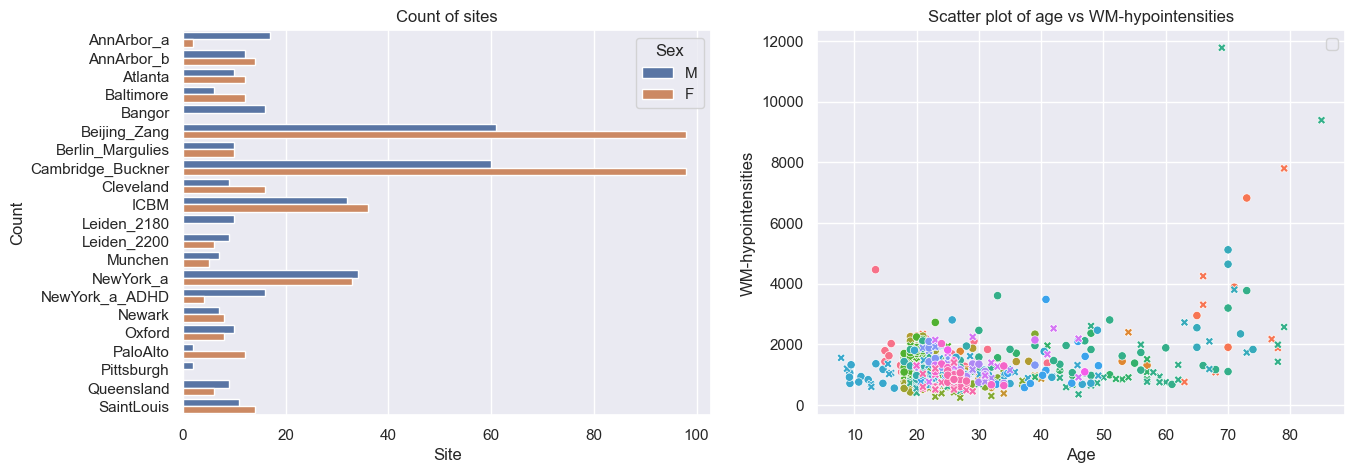

In [25]:
# Visualize the data
feature_to_plot = features_to_model[0]
df = train.to_dataframe()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df, y=("batch_effects", "site"), hue=("batch_effects", "sex"), ax=ax[0], orient="h")
ax[0].legend(title="Sex")
ax[0].set_title("Count of sites")
ax[0].set_xlabel("Site")
ax[0].set_ylabel("Count")
sns.scatterplot(
    data=df,
    x=("X", "age"),
    y=("Y", feature_to_plot),
    hue=("batch_effects", "site"),
    style=("batch_effects", "sex"),
    ax=ax[1],
)
ax[1].legend([], [])
ax[1].set_title(f"Scatter plot of age vs {feature_to_plot}")
ax[1].set_xlabel("Age")
ax[1].set_ylabel(feature_to_plot)

plt.show()

## Creating a Normative model

We will use the same HBR model that we used in the tutorial "Normative Modelling: Hierarchical Bayesian Regression with Normal likelihood". Please read that tutorial for an extensive coverage of the configuration. 

In [26]:
mu = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=make_prior(
        random=True,
        mu=make_prior(dist_name="Normal", dist_params=(0.0, 1.0)),
        sigma=make_prior(dist_name="Normal", dist_params=(0.0, 1.0), mapping="softplus", mapping_params=(0.0, 3.0)),
    ),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
)
sigma = make_prior(
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 2.0)),
    intercept=make_prior(dist_name="Normal", dist_params=(1.0, 1.0)),
    basis_function=BsplineBasisFunction(basis_column=0, nknots=5, degree=3),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)

likelihood = NormalLikelihood(mu, sigma)

template_hbr = HBR(
    name="template",
    cores=16,
    progressbar=True,
    draws=1500,
    tune=500,
    chains=4,
    nuts_sampler="nutpie",
    likelihood=likelihood,
)
model = NormativeModel(
    template_regression_model=template_hbr,
    savemodel=True,
    evaluate_model=True,
    saveresults=True,
    saveplots=False,
    save_dir="resources/hbr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
)

In [10]:
test = model.fit_predict(train, test)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,14,0.13,63
,2000,57,0.12,31
,2000,13,0.12,255
,2000,11,0.12,31


<xarray.NormData> Size: 44kB
Dimensions:            (observations: 186, response_vars: 1, covariates: 1,
                        batch_effect_dims: 2, centile: 5, statistic: 10)
Coordinates:
  * observations       (observations) int64 1kB 515 441 1029 64 ... 640 648 635
  * response_vars      (response_vars) <U18 72B 'WM-hypointensities'
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistic          (statistic) <U8 320B 'MACE' 'MAPE' ... 'SMSE' 'ShapiroW'
Data variables:
    subjects           (observations) object 1kB 'Cambridge_Buckner_sub83409'...
    Y                  (observations, response_vars) float64 1kB 1.113e+03 .....
    X                  (observations, covariates) float64 1kB 18.0 20.0 ... 20.0
    batch_effects      (observations, batch_effect_dims) <U17 25kB 'F' ... 'I...
    Z                  (observations, response_vars) float64 1kB -0.2964 ... ...
    centiles           (centile, observations, response_vars) float64 7kB 597...
    logp               (observations, response_vars) float64 1kB -0.2175 ... ...
    Yhat               (observations, response_vars) float64 1kB 1.226e+03 .....
    statistics         (response_vars, statistic) float64 80B 0.03011 ... 0.938
Attributes:
    real_ids:                       True
    is_scaled:                      False
    name:                           fit_test
    unique_batch_effects:           {'sex': ['F', 'M'], 'site': ['AnnArbor_a'...
    batch_effect_counts:            {'sex': {'F': 493, 'M': 437}, 'site': {'A...
    batch_effect_covariate_ranges:  {'sex': {'F': {'age': {'min': 7.88, 'max'...
    covariate_ranges:               {'age': {'min': 7.88, 'max': 85.0}}

/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:14:04 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


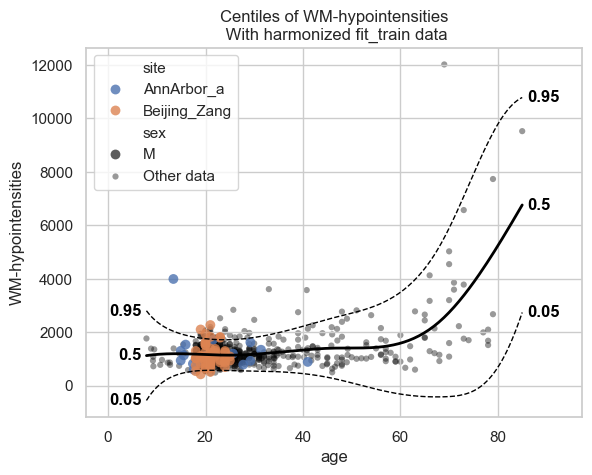

In [14]:
plot_centiles(
    model,
    centiles=[0.05, 0.5, 0.95],  # Plot these centiles, the default is [0.05, 0.25, 0.5, 0.75, 0.95]
    scatter_data=train,  # Scatter this data along with the centiles
    batch_effects={"site": ["Beijing_Zang", "AnnArbor_a"], "sex": ["M"]},  # Highlight these groups
    show_other_data=True,  # scatter data not in those groups as smaller black circles
    harmonize=True,  # harmonize the scatterdata, this means that we 'remove' the batch effects from the data, by simulating what the data would have looked like if all data was from the same batch.
)

## Extending

Now that we have a fitted model, we can extend it using the data that we held out of the train set. This is from previously unseen sites. Trying to run predict on it now, with the current model, will result in an error:

In [15]:
try:
    model.predict(transfer_train)
except Exception as e:
    print(e)

Data is not compatible with the model!


/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:14:05 - The dataset transfer_train has unknown batch effects: {'sex': [], 'site': ['Milwaukee_b', 'Oulu']}
  warnings.warn(message)


And just to show why we prefer extend over just fitting a new model on the held-out dataset, we can show how bad such a model would be:

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,3,0.13,63
,2000,3,0.13,127
,2000,2,0.15,63
,2000,3,0.14,31


/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:16:56 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


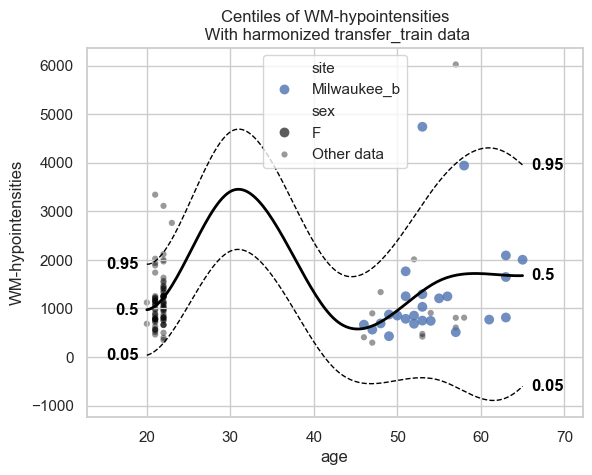

In [18]:
small_model = NormativeModel(
    template_regression_model=template_hbr,
    savemodel=True,
    evaluate_model=True,
    saveresults=True,
    saveplots=False,
    save_dir="resources/hbr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
)
small_model.fit_predict(transfer_train, transfer_test)
plot_centiles(
    small_model,
    centiles=[0.05, 0.5, 0.95],  # Plot these centiles, the default is [0.05, 0.25, 0.5, 0.75, 0.95]
    scatter_data=transfer_train,
    show_other_data=True,
    harmonize=True,
)

The interpolation between ages 22 and 45 is very bad, and that's because there was no train data there. This model will not perform well on new data. Now instead, let's transfer the model we fitted before to our smaller dataset, and see how those centiles look:


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,932,0.12,31
,2000,6,0.12,31
,2000,2,0.11,255
,2000,17,0.12,63


/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:19:13 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:19:17 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:19:18 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


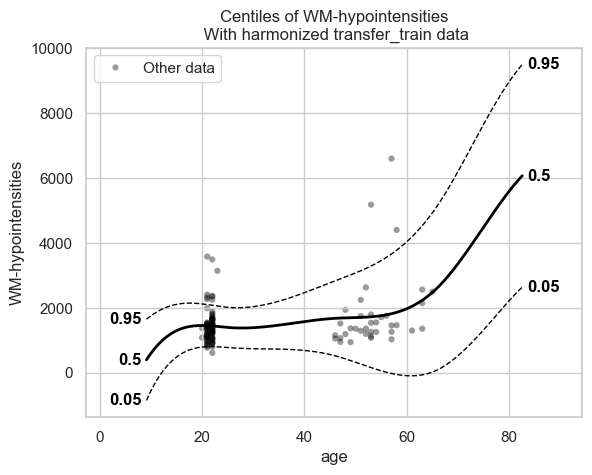

In [19]:
extended_model = model.extend_predict(transfer_train, transfer_test)
plot_centiles(
    extended_model,
    centiles=[0.05, 0.5, 0.95],  # Plot these centiles, the default is [0.05, 0.25, 0.5, 0.75, 0.95]
    scatter_data=transfer_train,
    show_other_data=True,
    harmonize=True,
)

These centiles look much better. The extended model is a larger model than the original one, it can be used on the original train data as well as the extended data:

In [21]:
extended_model.predict(train)

/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:21:57 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


<xarray.NormData> Size: 179kB
Dimensions:            (observations: 744, response_vars: 1, covariates: 1,
                        batch_effect_dims: 2, centile: 5, statistic: 10)
Coordinates:
  * observations       (observations) int64 6kB 459 995 432 ... 1023 1062 372
  * response_vars      (response_vars) <U18 72B 'WM-hypointensities'
  * covariates         (covariates) <U3 12B 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistic          (statistic) <U8 320B 'MACE' 'MAPE' ... 'SMSE' 'ShapiroW'
Data variables:
    subjects           (observations) object 6kB 'Cambridge_Buckner_sub53615'...
    Y                  (observations, response_vars) float64 6kB 974.0 ... 1....
    X                  (observations, covariates) float64 6kB 19.0 29.0 ... 25.0
    batch_effects      (observations, batch_effect_dims) <U17 101kB 'M' ... '...
    Z                  (observations, response_vars) float64 6kB -1.048 ... 2...
    centiles           (centile, observations, response_vars) float64 30kB 76...
    logp               (observations, response_vars) float64 6kB -0.7252 ... ...
    Yhat               (observations, response_vars) float64 6kB 1.409e+03 .....
    statistics         (response_vars, statistic) float64 80B 0.04194 ... 0.9058
    Y_harmonized       (observations, response_vars) float64 6kB 1.013e+03 .....
Attributes:
    real_ids:                       True
    is_scaled:                      False
    name:                           fit_train
    unique_batch_effects:           {'sex': ['F', 'M'], 'site': ['AnnArbor_a'...
    batch_effect_counts:            {'sex': {'F': 493, 'M': 437}, 'site': {'A...
    batch_effect_covariate_ranges:  {'sex': {'F': {'age': {'min': 7.88, 'max'...
    covariate_ranges:               {'age': {'min': 7.88, 'max': 85.0}}

## Transfering

Transfering looks very similar to extending, but the underlying mathematics is very different. Besides that, it leads to a smaller model instead of a bigger one; we can _not_ use a transfered model on the original train data.  

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,5,0.22,63
,2000,4,0.22,63
,2000,5,0.23,31
,2000,2,0.20,63


/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:25:01 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:25:05 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)
/opt/anaconda3/envs/uv_refactor/lib/python3.12/site-packages/pcntoolkit/util/output.py:218: UserWarning: Process: 3614 - 2025-06-24 11:25:07 - remove_Nan is set to False. Ensure your data does not contain NaNs in critical columns, or handle them appropriately.
  warnings.warn(message)


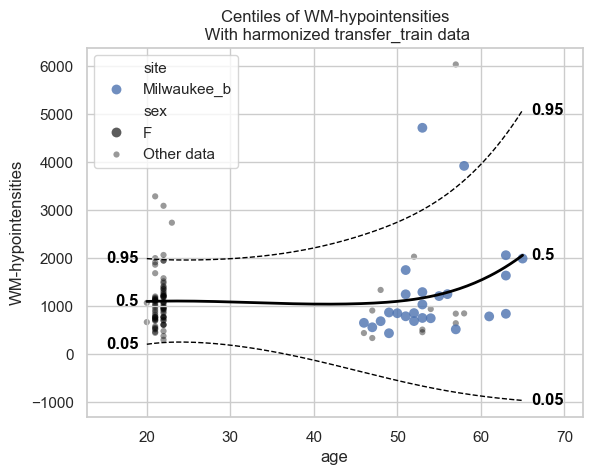

In [22]:
transfered_model = model.transfer_predict(transfer_train, transfer_test)
plot_centiles(
    transfered_model,
    centiles=[0.05, 0.5, 0.95],  # Plot these centiles, the default is [0.05, 0.25, 0.5, 0.75, 0.95]
    scatter_data=transfer_train,
    show_other_data=True,
    harmonize=True,
)

Here we see that the transfered model is also much better than the 'small model' that we trained directly on the small dataset.  